In [68]:
import pandas as pd
from datetime import datetime

# 读取因子数据和股票数据
factor_data = pd.read_csv('icmean_date_asset.csv') 
factor_data['date'] = pd.to_datetime(factor_data['date'])
factor_data['date'] = pd.to_datetime(factor_data['date']) + pd.DateOffset(years=1)

stock_data = pd.read_csv('kline_data_2022-2023.csv')
stock_data['date'] = stock_data['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
stock_data = stock_data.set_index(['asset', 'date'])

# 合并因子数据和股票数据
merged_data = pd.merge(stock_data, factor_data, on=['date', 'asset'], how='inner')

# 设置初始投资金额和投资比例
initial_investment = 100000  # 假设初始投资金额为 100,000
investment_percentage = 0.1  # 假设每次投资比例为初始投资的 10%

# 初始化记录交易的 DataFrame
trades = pd.DataFrame(columns=['date', 'asset', 'action', 'price', 'quantity'])


# 初始化记录每天现金的列表
daily_cash = []


# 模拟交易并记录每次交易
cash = initial_investment
portfolio_values = []
for date, row in merged_data.iterrows():
    daily_cash.append({'date': date, 'cash': cash})  # 记录每天的现金
    if row['synthesized_factor'] >= 0:  # 买入信号
        investment_amount = initial_investment * investment_percentage
        portfolio_values.append(investment_amount * (row['close_price'] / row['open_price']))
        
        # 记录买入交易
        new_trade = pd.DataFrame({'date': [date], 'asset': [row['asset']], 'action': ['buy'], 'price': [row['close_price']], 'quantity': [investment_amount / row['close_price']]})
        trades = pd.concat([trades, new_trade], ignore_index=True)
        
    else:
        # 如果持有该股票且股票因子低于阈值，卖出股票
        if row['asset'] in trades['asset'].values and row['synthesized_factor'] < 0:
            stock_to_sell = trades[(trades['asset'] == row['asset']) & (trades['action'] == 'buy')]
            cash += row['close_price'] * stock_to_sell['quantity'].sum()
            trades = trades[~((trades['asset'] == row['asset']) & (trades['action'] == 'buy'))]  # 移除已卖出的股票记录
        
        portfolio_values.append(cash + (trades[trades['action'] == 'buy']['price'] * trades[trades['action'] == 'buy']['quantity']).sum())
        daily_cash[-1]['cash'] = cash  # 更新当天现金
        
# 计算收益率
returns = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
annualized_returns = returns * (252 / len(portfolio_values))  # 假设一年有252个交易日


# 输出结果
print(f"年化收益率: {annualized_returns}")


年化收益率: 0.27178825950167107


## 2

In [72]:
import pandas as pd
from datetime import datetime

# 读取因子数据和股票数据
factor_data = pd.read_csv('icmean_date_asset.csv') 
factor_data['date'] = pd.to_datetime(factor_data['date'])
factor_data['date'] = pd.to_datetime(factor_data['date']) + pd.DateOffset(years=1)

stock_data = pd.read_csv('kline_data_2022-2023.csv')
stock_data['date'] = stock_data['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
stock_data = stock_data.set_index(['asset', 'date'])

# 合并因子数据和股票数据
merged_data = pd.merge(stock_data, factor_data, on=['date', 'asset'], how='inner')

# 设置初始投资金额和投资比例
initial_investment = 100000  # 假设初始投资金额为 100,000
investment_percentage = 0.1  # 假设每次投资比例为初始投资的 10%

# 初始化记录交易的 DataFrame
trades = pd.DataFrame(columns=['date', 'asset', 'action', 'price', 'quantity'])


# 初始化记录每天现金的列表
daily_cash = []


# 模拟交易并记录每次交易
cash = initial_investment
portfolio_values = []

for date, group in merged_data.groupby('date'):
    daily_cash.append({'date': date, 'cash': cash})  # 记录每天的现金
    
    for index, row in group.iterrows():
        if row['synthesized_factor'] > 3:  # 买入信号
            # ...（买入操作）
            investment_amount = initial_investment * investment_percentage
            portfolio_values.append(investment_amount * (row['close_price'] / row['open_price']))
        
            # 记录买入交易
            new_trade = pd.DataFrame({'date': [date], 'asset': [row['asset']], 'action': ['buy'], 'price': [row['close_price']], 'quantity': [investment_amount / row['close_price']]})
            trades = pd.concat([trades, new_trade], ignore_index=True)

        else:
            # ...（卖出操作）
            stock_to_sell = trades[(trades['asset'] == row['asset']) & (trades['action'] == 'buy')]
            cash += row['close_price'] * stock_to_sell['quantity'].sum()
            trades = trades[~((trades['asset'] == row['asset']) & (trades['action'] == 'buy'))]  # 移除已卖出的股票记录

    
    # 更新当天的现金
    cash = cash + (trades[trades['action'] == 'buy']['price'] * trades[trades['action'] == 'buy']['quantity']).sum()
    daily_cash[-1]['cash'] = cash  # 更新当天现金

# 将每日现金数据转换为 DataFrame 并保存到 CSV 文件
daily_cash_df = pd.DataFrame(daily_cash)
daily_cash_df.to_csv('daily_cash.csv', index=False)


# 计算收益率
returns = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
annualized_returns = returns * (252 / len(portfolio_values))  # 假设一年有252个交易日


# 输出结果
print(f"年化收益率: {annualized_returns}")


年化收益率: -4.498912301149641e-05


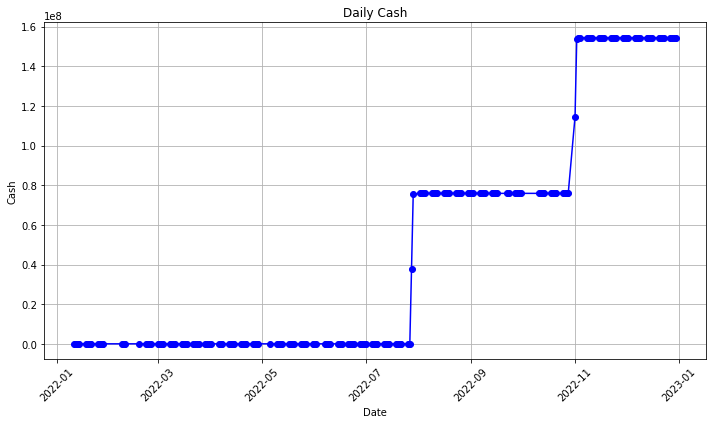

最大回撤: -0.1263193968471556
调仓频率(每年): 61.09778334531727
换手率: 0.24245152121157648


In [74]:
import matplotlib.pyplot as plt

# 生成策略的收益曲线
# dates = merged_data.reset_index()['date']  # 重置索引以获取日期列
# plt.figure(figsize=(10, 6))
# plt.plot(portfolio_values)
# plt.xlabel('date')
# plt.ylabel('value')
# plt.title('line')
# plt.grid(True)
# plt.show()

# 读取 daily_cash 数据
daily_cash_df = pd.read_csv('daily_cash.csv')
daily_cash_df['date'] = pd.to_datetime(daily_cash_df['date'])  # 转换日期列为 datetime64 类型

# 绘制收益曲线
plt.figure(figsize=(10, 6))
plt.plot(daily_cash_df['date'], daily_cash_df['cash'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cash')
plt.title('Daily Cash')
plt.xticks(rotation=45)  # 旋转 x 轴标签，使其更易读
plt.grid(True)
plt.tight_layout()
plt.show()


# 计算最大回撤
cumulative_returns = pd.Series(portfolio_value) / initial_investment
drawdowns = (cumulative_returns - cumulative_returns.cummax())
max_drawdown = drawdowns.min()

# 计算调仓频率（这里简单地以买卖次数来计算）
trades_count = sum(1 for val in portfolio_value if val != 0)
trades_per_year = trades_count / (len(portfolio_value) / 252)  # 假设一年有252个交易日

# 计算换手率（这里简单地以买卖次数与投资组合总额的比率来计算）
turnover_rate = trades_count / len(portfolio_value)

# 输出结果
print(f"最大回撤: {max_drawdown}")
print(f"调仓频率(每年): {trades_per_year}")
print(f"换手率: {turnover_rate}")


In [61]:
# 计算夏普比率
daily_returns = pd.Series(portfolio_value).pct_change().dropna()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * (252**0.5)  # 假设一年有252个交易日
print(f"夏普比率: {sharpe_ratio}")

夏普比率： 0.002383454894509927
